In [1]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from subprocess import check_output
import utils

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#Load data
train = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/train.json")
valid = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/valid.json")
test = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
valid.inc_angle = valid.inc_angle.replace('na', 0)
valid.inc_angle = valid.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [3]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

In [4]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=1)
ships = train[train.is_iceberg==0].sample(n=9,random_state=1)

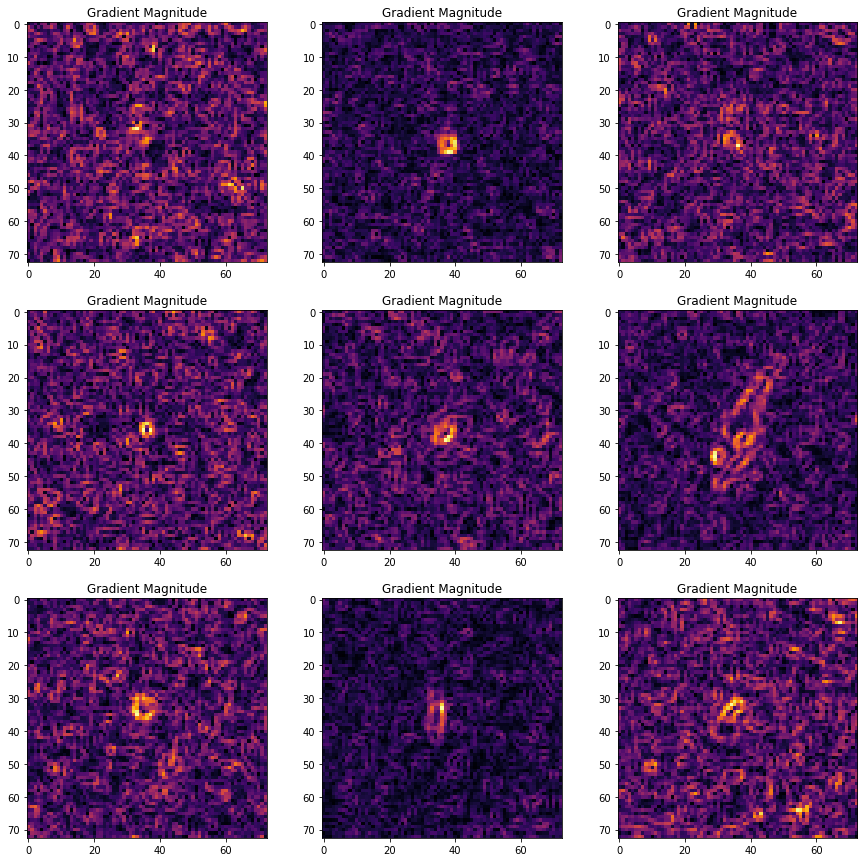

In [14]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

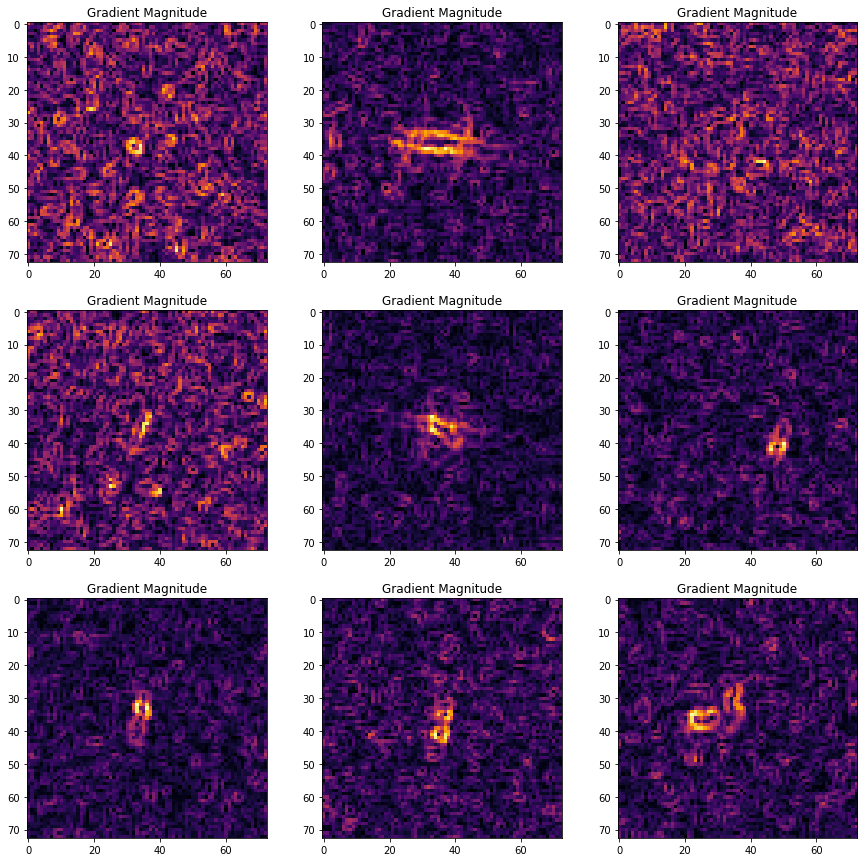

In [15]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.set_title('Gradient Magnitude')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    
    
plt.show()

In [16]:
# Train data
x_band1 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in train["band_1"]]) 
x_band2 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in train["band_2"]]) 
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Valid data
x_band1 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in valid["band_1"]]) 
x_band2 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in valid["band_2"]])
X_valid = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_valid = np.array(valid.inc_angle)
y_valid = np.array(valid["is_iceberg"])

# Test data
x_band1 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in test["band_1"]]) 
x_band2 = np.array([np.hypot(signal.convolve2d(np.reshape(np.array(band),(75,75)),xder,mode='valid'),signal.convolve2d(np.reshape(np.array(band),(75,75)),yder,mode='valid')) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

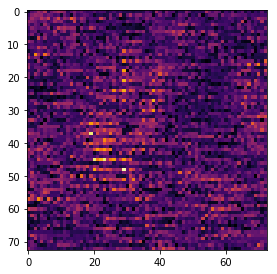

In [17]:
fig = plt.figure(1,figsize=(15,15))
ax = fig.add_subplot(3,3,1)
ax.imshow(X_valid[10].reshape(3,73,73)[1],cmap='inferno')
plt.show()

In [18]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
model = utils.keras_baselilne()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_33 (Conv2D)               (None, 73, 73, 16)    448         X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_34 (Conv2D)               (None, 71, 71, 16)    2320        conv2d_33[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D)  (None, 35, 35, 16)    0           conv2d_34[0][0]                  
___________________________________________________________________________________________

In [19]:
file_path = "/mnt/extDisk/courses/data/statoil/data/pre_process/.model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=30)

reload(utils)
model = utils.keras_baselilne(73,73)
model.fit([X_train,X_angle_train], y_train, epochs=20
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 602 samples, validate on 200 samples
Epoch 1/20
602/602 [==============================] - 1s - loss: 0.9180 - acc: 0.5880 - val_loss: 0.6274 - val_acc: 0.7650
Epoch 2/20
602/602 [==============================] - 0s - loss: 0.8248 - acc: 0.6429 - val_loss: 0.6070 - val_acc: 0.7650
Epoch 3/20
602/602 [==============================] - 0s - loss: 0.7369 - acc: 0.6977 - val_loss: 0.5944 - val_acc: 0.7750
Epoch 4/20
602/602 [==============================] - 0s - loss: 0.6920 - acc: 0.6927 - val_loss: 0.4598 - val_acc: 0.7650
Epoch 5/20
602/602 [==============================] - 0s - loss: 0.5308 - acc: 0.7558 - val_loss: 0.3387 - val_acc: 0.8850
Epoch 6/20
602/602 [==============================] - 0s - loss: 0.4781 - acc: 0.7741 - val_loss: 0.3124 - val_acc: 0.8850
Epoch 7/20
602/602 [==============================] - 0s - loss: 0.4670 - acc: 0.7774 - val_loss: 0.4366 - val_acc: 0.8100
Epoch 8/20
602/602 [==============================] - 0s - loss: 0.3558 - acc: 0.8455 - val_l

In [13]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
600/602 [============================>.] - ETA: 0s[0.18188619361169314, 0.93687713661067118]
####################
watch list evaluate:
200/200 [==============================] - 0s
[0.29813894629478455, 0.88499999046325684]


In [ ]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

In [ ]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

In [ ]:
submission.to_csv("/mnt/extDisk/courses/data/statoil/data/pre_process/pre_process.csv", index=False)